## 2022 NYC Taxi Data Analysis

## Introduction
### Main question: Do taxi fees affect people's decision of whether or not to take the taxi in NYC during 2022?
##### Notes: I created this analysis initially in Databricks. 
##### Data came from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

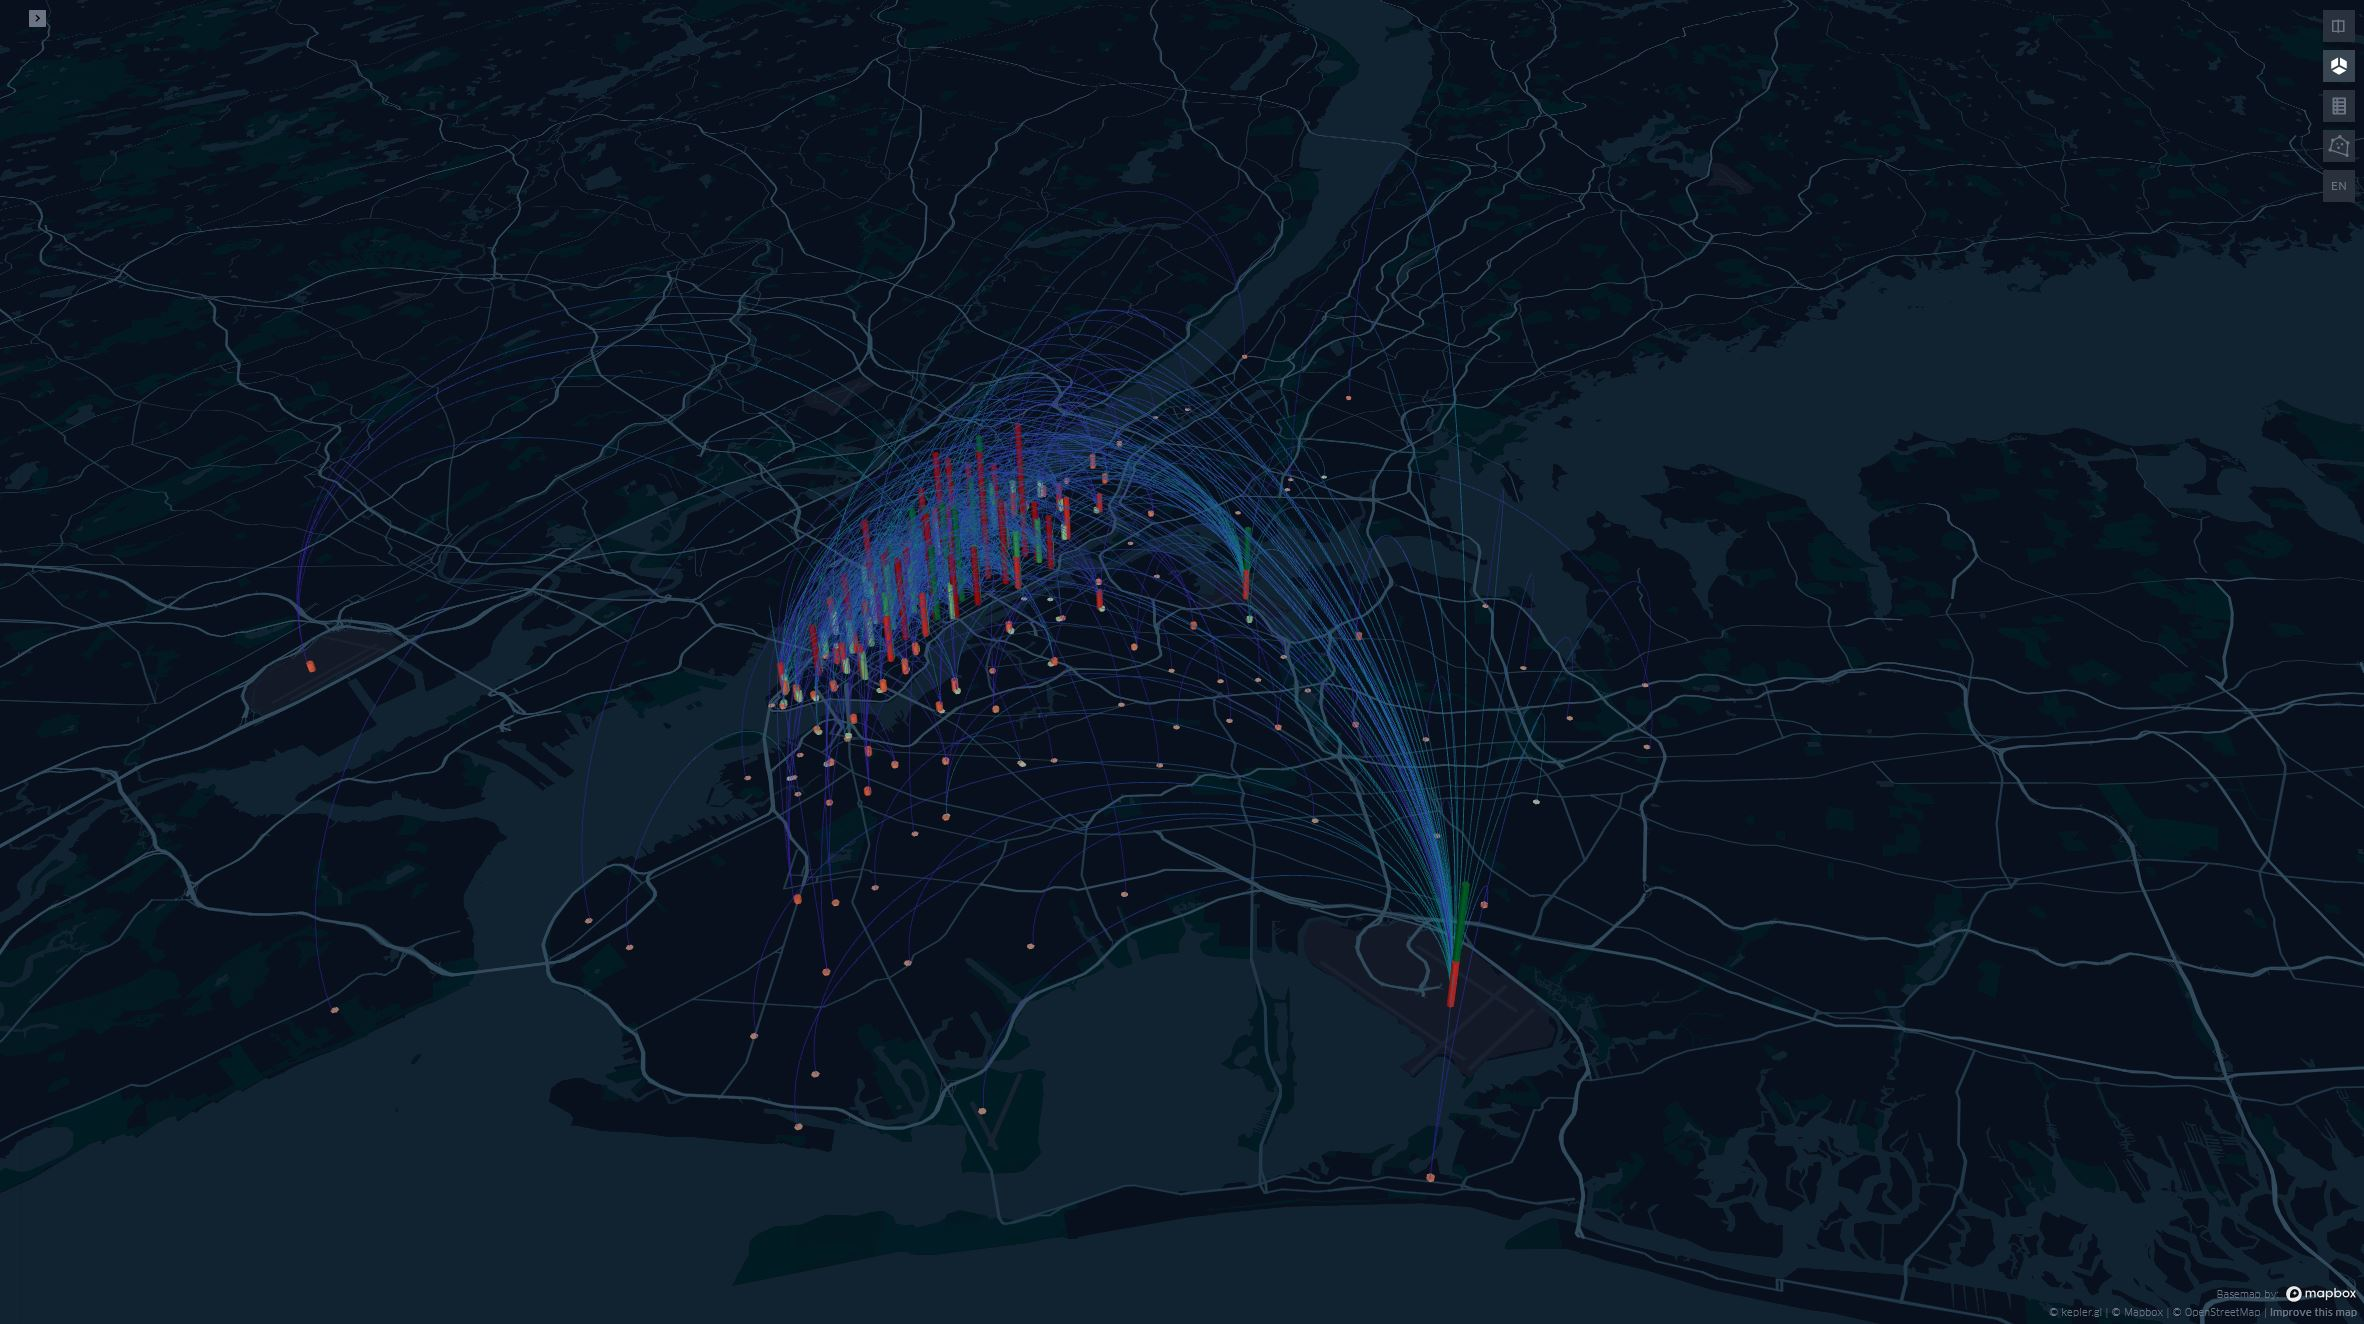

## Installing Relevant Packages, Modules
##### note: make sure to install graphframes jar

In [1]:
!pip install keplergl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 42.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922320 sha256=dedf86638ce53321b5b476a2ba9ddff8653bf2fdf30c5314f8a47fbbdbf21a18
  Stored in directory: /root/.cache/pip/wheels/1f/30/1d/c13f5030f6e73cecb8d7bb3210ee28fce4f25717ddfcb03ed2
Successfully built keplergl


In [2]:
!pip install graphframes

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=ab0bd7394c2ab344dda7b141fa851964d3e5006637f070ca713dc4971df8b1ac
  Stored in directory: /root/.cache/pip/wheels/81/1b/c2/e41f4bddafe5564d11b2414a62dd7f5d75fcf65b2d7b7805c4
Successfully built pyspark


In [4]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from graphframes import GraphFrame
from keplergl import KeplerGl
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Data Processing and Cleaning
##### Note that it's preferable to run sample size at least 0.005 of original dataset size. Otherwise, if sample size is too small, searching for the top 3 trips per month (below section with bar graph) will become more difficult since there won't be as much data to distinguish different trips and it will become likely that there will be multiple trips competing for the same ranking spot. 

In [5]:
#Begin a spark session
spark = SparkSession.builder \
                    .appName("NYCTaxiAnalysis_2022") \
                    .config("spark.jars.packages", "graphframes:graphframes:0.8.0-spark3.0-s_2.12") \
                    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.7/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ced8241d-bfef-481c-9e86-6b383a84ee81;1.0
	confs: [default]
	found graphframes#graphframes;0.8.0-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.0-spark3.0-s_2.12/graphframes-0.8.0-spark3.0-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.0-spark3.0-s_2.12!graphframes.jar (31ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.16!slf4j-api.jar (327ms)
:: resolution report :: resolve 2824ms :: artifacts dl 363ms
	:: modules in use:
	graphframes#graphframes;0.8.0-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	-----------------------

In [6]:
#Read in the data and grab a small sample size
df_2022_01 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_01.parquet").fillna('').sample(0.01)
df_2022_02 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_02.parquet").fillna('').sample(0.01)
df_2022_03 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_03.parquet").fillna('').sample(0.01)
df_2022_04 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_04.parquet").fillna('').sample(0.01)
df_2022_05 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_05.parquet").fillna('').sample(0.01)
df_2022_06 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_06.parquet").fillna('').sample(0.01)
df_2022_07 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_07.parquet").fillna('').sample(0.01)
df_2022_08 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_08.parquet").fillna('').sample(0.01)
df_2022_09 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_09.parquet").fillna('').sample(0.01)
df_2022_10 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_10.parquet").fillna('').sample(0.01)
df_2022_11 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_11.parquet").fillna('').sample(0.01)
df_2022_12 = spark.read.options(header="true").parquet("../input/nyctaxi2022/yellow_tripdata_2022_12.parquet").fillna('').sample(0.01)
df_location_mapping = spark.read.format("csv").option("header", "true").load("../input/nyctaxi2022/location_mapping.csv")

In [7]:
#Joining the files together and then renaming columns to distinguish between pickup coordinates vs dropoff coordinates
df_2022 = df_2022_01.union(df_2022_02).union(df_2022_03).union(df_2022_04).union(df_2022_05).union(df_2022_06).union(df_2022_07).union(df_2022_08).union(df_2022_09).union(df_2022_10).union(df_2022_11).union(df_2022_12)
df_2022_joinedPU = df_2022.join(df_location_mapping, df_2022.PULocationID == df_location_mapping.location_i, "inner")
df_2022_joinedPURenamed = df_2022_joinedPU.withColumnRenamed("X", "PULon").withColumnRenamed("Y", "PULat").withColumnRenamed("borough", "PUborough").withColumnRenamed("location_i", "PUlocation_i").withColumnRenamed("shape_area", "PUshape_area").withColumnRenamed("shape_leng", "PUshape_leng").withColumnRenamed("zone", "PUzone").drop("objectid")
df_2022_joinedPUDO = df_2022_joinedPURenamed.join(df_location_mapping, df_2022_joinedPURenamed.DOLocationID == df_location_mapping.location_i, "inner")
df_2022_joinedPUDORenamed = df_2022_joinedPUDO.withColumnRenamed("X", "DOLon").withColumnRenamed("Y", "DOLat").withColumnRenamed("borough", "DOborough").withColumnRenamed("location_i", "DOlocation_i").withColumnRenamed("shape_area", "DOshape_area").withColumnRenamed("shape_leng", "DOshape_leng").withColumnRenamed("zone", "DOzone").drop("objectid")
df_2022_cleaned = df_2022_joinedPUDORenamed.fillna('')

In [8]:
df_2022_cleaned.count()

388370

In [9]:
df_2022_cleaned.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- PULon: string (nullable = false)
 |-- PULat: string (nullable = false)
 |-- PUborough: string (nullable = false)
 |-- PUlocat

In [10]:
df_2022_cleaned.show(5, truncate=False)

23/05/05 04:54:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+----------------+---------+------------+-----------------+---------------+-----------------------------+-----------------+----------------+---------+------------+-----------------+---------------+-------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|PULon            |PULat           |PUborough|PUlocation_i|PUshape_area     |PUshape_leng   |PUzone                       |DOLon            |DOLat           |DOborough|DOlocation_i|DOshape_area     |DOshape_leng   |DOzon

In [11]:
#Add column for Month and display the month name rather than the month number
df_2022_cleaned = df_2022_cleaned.withColumn("Month", when(month("tpep_pickup_datetime") == 1, "Jan").when(month("tpep_pickup_datetime") == 2, "Feb").when(month("tpep_pickup_datetime") == 3, "Mar").when(month("tpep_pickup_datetime") == 4, "Apr").when(month("tpep_pickup_datetime") == 5, "May").when(month("tpep_pickup_datetime") == 6, "Jun").when(month("tpep_pickup_datetime") == 7, "Jul").when(month("tpep_pickup_datetime") == 8, "Aug").when(month("tpep_pickup_datetime") == 9, "Sep").when(month("tpep_pickup_datetime") == 10, "Oct").when(month("tpep_pickup_datetime") == 11, "Nov").when(month("tpep_pickup_datetime") == 12, "Dec"))

## Plots

In [12]:
def get_month(month):
    if month == 1:
        return "Jan"
    elif month == 2:
        return "Feb"
    elif month == 3:
        return "Mar"
    elif month == 4:
        return "Apr"
    elif month == 5:
        return "May"
    elif month == 6:
        return "June"
    elif month == 7:
        return "Jul"
    elif month == 8:
        return "Aug"
    elif month == 9:
        return "Sep"
    elif month == 10:
        return "Oct"
    elif month == 11:
        return "Nov"
    elif month == 12:
        return "Dec"

In [13]:
#For the number of trips subplot below
num_of_trips = df_2022_cleaned.groupBy(expr("month(tpep_pickup_datetime) as Month")).agg(expr("count(RatecodeID) as NumOfTrips")).orderBy(asc("Month"))
x_months_num_of_trips = [get_month(each.Month) for each in num_of_trips.select("Month").collect()]
y_num_of_trips = [num for num in num_of_trips.select("NumOfTrips").collect()]

In [14]:
#For the total fees subplot below
avg_total_per_month = df_2022_cleaned.groupBy(expr("month(tpep_pickup_datetime) as Month")).agg(expr("avg(total_amount) as AverageFee")).orderBy(asc("Month"))
x_months_avg_total_per_month = [get_month(each.Month) for each in avg_total_per_month.select("Month").collect()]
y_avg_total_per_month = [num for num in avg_total_per_month.select("AverageFee").collect()]

In [15]:
#For the average fare subplot below
avg_fare_per_month = df_2022_cleaned.groupBy(expr("month(tpep_pickup_datetime) as Month")).agg(expr("avg(fare_amount) as FareAmount")).orderBy(asc("Month"))
x_months_avg_fare_per_month = [get_month(each.Month) for each in avg_fare_per_month.select("Month").collect()]
y_avg_fare_per_month = [num for num in avg_fare_per_month.select("FareAmount").collect()]

In [16]:
#For the average tip subplot below
avg_tip_per_month = df_2022_cleaned.groupBy(expr("month(tpep_pickup_datetime) as Month")).agg(expr("avg(tip_amount) as TipAmount")).orderBy(asc("Month"))
x_months_avg_tip_per_month = [get_month(each.Month) for each in avg_tip_per_month.select("Month").collect()]
y_avg_tip_per_month = [num for num in avg_tip_per_month.select("TipAmount").collect()]

In [17]:
#For the average trip distance subplot below
avg_trip_distance_per_month = df_2022_cleaned.groupBy(expr("month(tpep_pickup_datetime) as Month")).agg(expr("avg(trip_distance) as TripDistance")).orderBy(asc("Month"))
x_months_avg_trip_distance_per_month = [get_month(each.Month) for each in avg_trip_distance_per_month.select("Month").collect()]
y_avg_trip_distance_per_month = [num for num in avg_trip_distance_per_month.select("TripDistance").collect()]

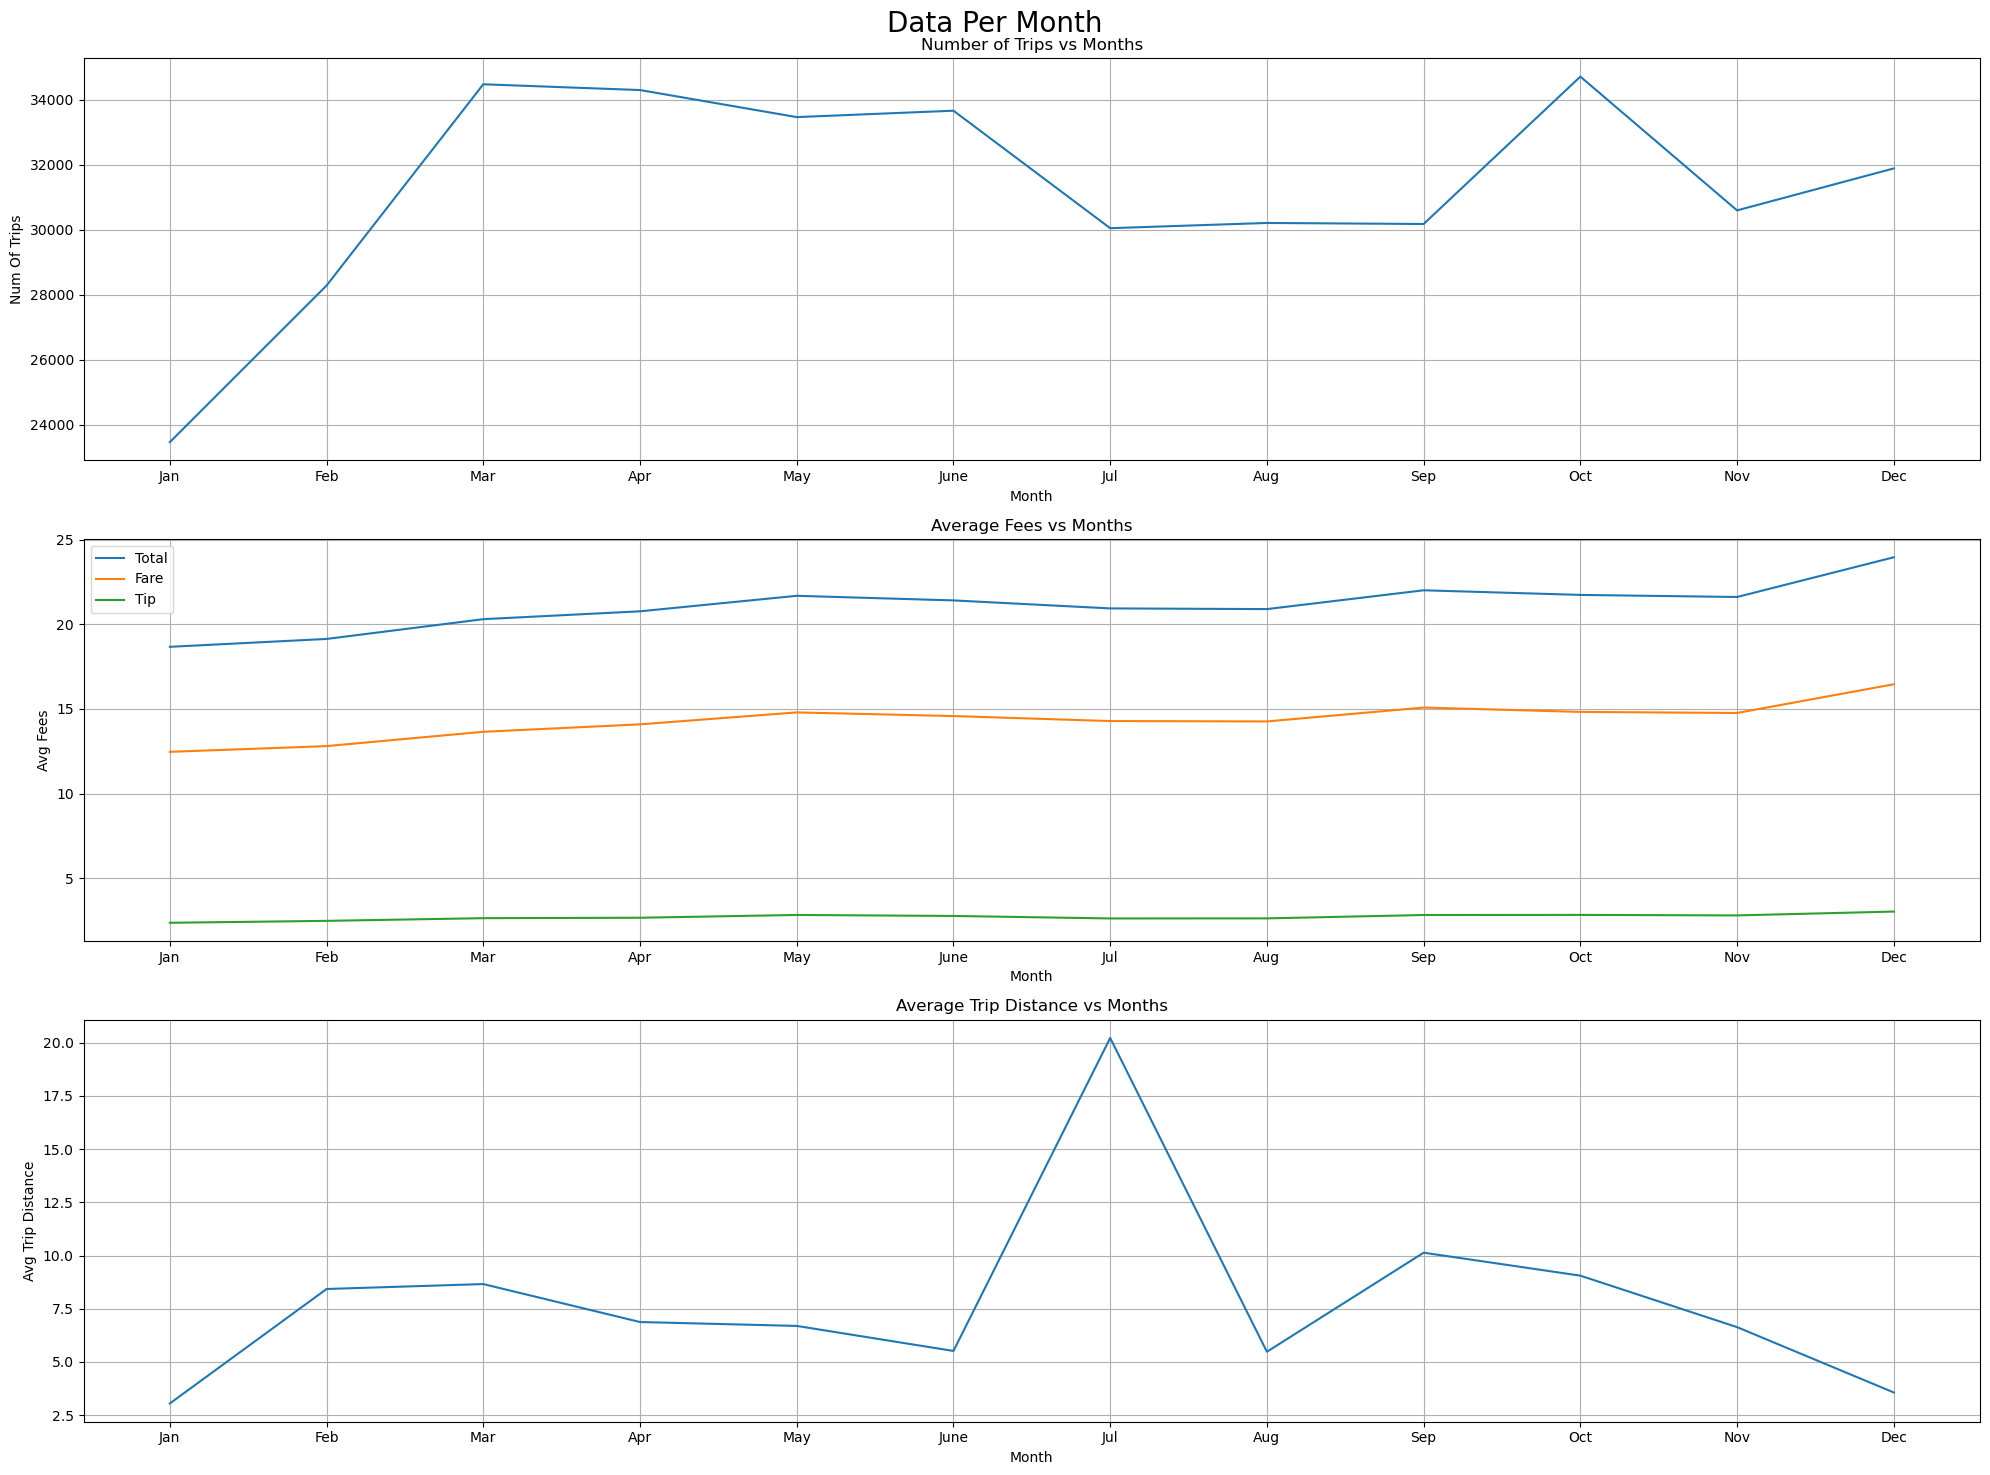

In [18]:
#Display the plots
fig, axs = plt.subplots(3, 1, figsize=(20,15))

axs[0].plot(x_months_num_of_trips, y_num_of_trips)
axs[0].set_title('Number of Trips vs Months')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Num Of Trips')
axs[0].grid(True)

total_line, = axs[1].plot(x_months_avg_total_per_month, y_avg_total_per_month, label='Total')
fare_line, = axs[1].plot(x_months_avg_fare_per_month, y_avg_fare_per_month, label='Fare')
tip_line, = axs[1].plot(x_months_avg_tip_per_month, y_avg_tip_per_month, label='Tip')
axs[1].legend(handles=[total_line, fare_line, tip_line])
axs[1].set_title('Average Fees vs Months')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Avg Fees')
axs[1].grid(True)

axs[2].plot(x_months_avg_trip_distance_per_month, y_avg_trip_distance_per_month)
axs[2].set_title('Average Trip Distance vs Months')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Avg Trip Distance')
axs[2].grid(True)

fig.suptitle('Data Per Month', fontsize=20)
fig.tight_layout()

## Analysis for Plots
##### The number of trips increased linearly from January to March, plateaued in March and stayed fairly constant until June. The number of trips decreased from June to July, stayed constant between July and September, then increased again in October, decreased in November, then increased again in December, but only slightly.
##### The number of trips in December (considering it being holiday season) did not reach as high as it did in March. This may be due to snowfall that led people to use other means of transportation such as the subway. This is supported by the third graph (Avg Trip Distance vs Months) showing that the average trip distance during both Q1 and Q4 having lower average trip distance than that during Q2 and Q3. Summertime is when there is both a high number of trips and also a high average trip distance. This coincides with summer when people may be traveling for vacation while also having non-snow weather. Since it's June, it's likely that they wanted to avoid the hot weather.
##### The average fees for riding in a taxi stayed fairly constant throughout the year. There is a small increase in December.

## GraphFrames

In [19]:
#Create GraphFrame of dst and src spots and the trip in between
tripVertices = df_2022_cleaned.withColumnRenamed("PUZone", "id").distinct()
tripEdges = df_2022_cleaned.withColumnRenamed("PUZone", "src").withColumnRenamed("DOZone", "dst")
tripGraph = GraphFrame(tripVertices, tripEdges)

/opt/conda/lib/python3.7/site-packages/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  "DataFrame.sql_ctx is an internal property, and will be removed "


In [20]:
#Count number of occurrence for each trip
ordered_trips_by_month = tripGraph.edges.groupBy(expr("month(tpep_pickup_datetime) as month"),"src","dst").count().orderBy(asc("month"))

In [21]:
#Create a sql view should I want to query directly using sql
ordered_trips_by_month.createOrReplaceTempView("orderedTripsByMonth")

In [22]:
#Total number of trips
ordered_trips_by_month.count()

55342

In [23]:
ordered_trips_by_month.show(5, truncate=False)

+-----+-------------------------+------------------------------+-----+
|month|src                      |dst                           |count|
+-----+-------------------------+------------------------------+-----+
|1    |Lincoln Square East      |Crotona Park East             |1    |
|1    |Upper East Side North    |Lenox Hill East               |55   |
|1    |Clinton West             |Washington Heights South      |3    |
|1    |Garment District         |Lenox Hill West               |8    |
|1    |West Chelsea/Hudson Yards|Stuy Town/Peter Cooper Village|2    |
+-----+-------------------------+------------------------------+-----+
only showing top 5 rows



In [24]:
#Get the top 3 most frequent trips per month. then create a column that concatenates the src and dst as a single string for each row
window = Window.partitionBy(ordered_trips_by_month['month']).orderBy(ordered_trips_by_month['count'].desc())
top_three_per_month = ordered_trips_by_month.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 3).select("*", concat("src", lit(" to "), "dst").alias("trip"))
top_three_per_month_abbr = top_three_per_month.withColumn("trip_abbr", concat(array_join(expr("transform(split(src, ' '), x -> left(x,1))"),""),lit(" to "), array_join(expr("transform(split(src, ' '), x -> left(x,1))"),"")))

In [25]:
top_three_per_month_abbr.show(5, truncate=False)

+-----+---------------------+---------------------+-----+----+----------------------------------------------+------------+
|month|src                  |dst                  |count|rank|trip                                          |trip_abbr   |
+-----+---------------------+---------------------+-----+----+----------------------------------------------+------------+
|1    |Upper East Side South|Upper East Side North|175  |1   |Upper East Side South to Upper East Side North|UESS to UESS|
|1    |Upper East Side North|Upper East Side South|173  |2   |Upper East Side North to Upper East Side South|UESN to UESN|
|1    |Upper East Side North|Upper East Side North|148  |3   |Upper East Side North to Upper East Side North|UESN to UESN|
|2    |Upper East Side South|Upper East Side North|210  |1   |Upper East Side South to Upper East Side North|UESS to UESS|
|2    |Upper East Side North|Upper East Side South|179  |2   |Upper East Side North to Upper East Side South|UESN to UESN|
+-----+---------

## Graph

In [26]:
months = ("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

In [27]:
#Prepping the data (top 3 trips per month) to use to generate bar graph below
rank1 = []
rank2 = []
rank3 = []

trip_name1 = []
trip_name2 = []
trip_name3 = []

for each in top_three_per_month_abbr.select("rank", "count", "month", "trip_abbr").collect():
    if each.rank == 1:
        rank1.append(each["count"])
        trip_name1.append(each["trip_abbr"])
    elif each.rank == 2:
        rank2.append(each["count"])
        trip_name2.append(each["trip_abbr"])
    elif each.rank == 3:
        rank3.append(each["count"])
        trip_name3.append(each["trip_abbr"])

counts = {
    '1st Most Popular Trip':rank1,
    '2nd Most Popular Trip':rank2,
    '3rd Most Popular Trip':rank3
}

In [28]:
#Show the trip labels within each bar in the bar graph below
def print_trip_name(counter):
    trip_labels = []
    for i in range(0,len(months)): 
        if counter == 0:
            trip_labels.append('\n'.join(trip_name1[i]))
        elif counter == 1:
            trip_labels.append('\n'.join(trip_name2[i]))
        elif counter == 2:
            trip_labels.append('\n'.join(trip_name3[i]))                                   
    return list(trip_labels)

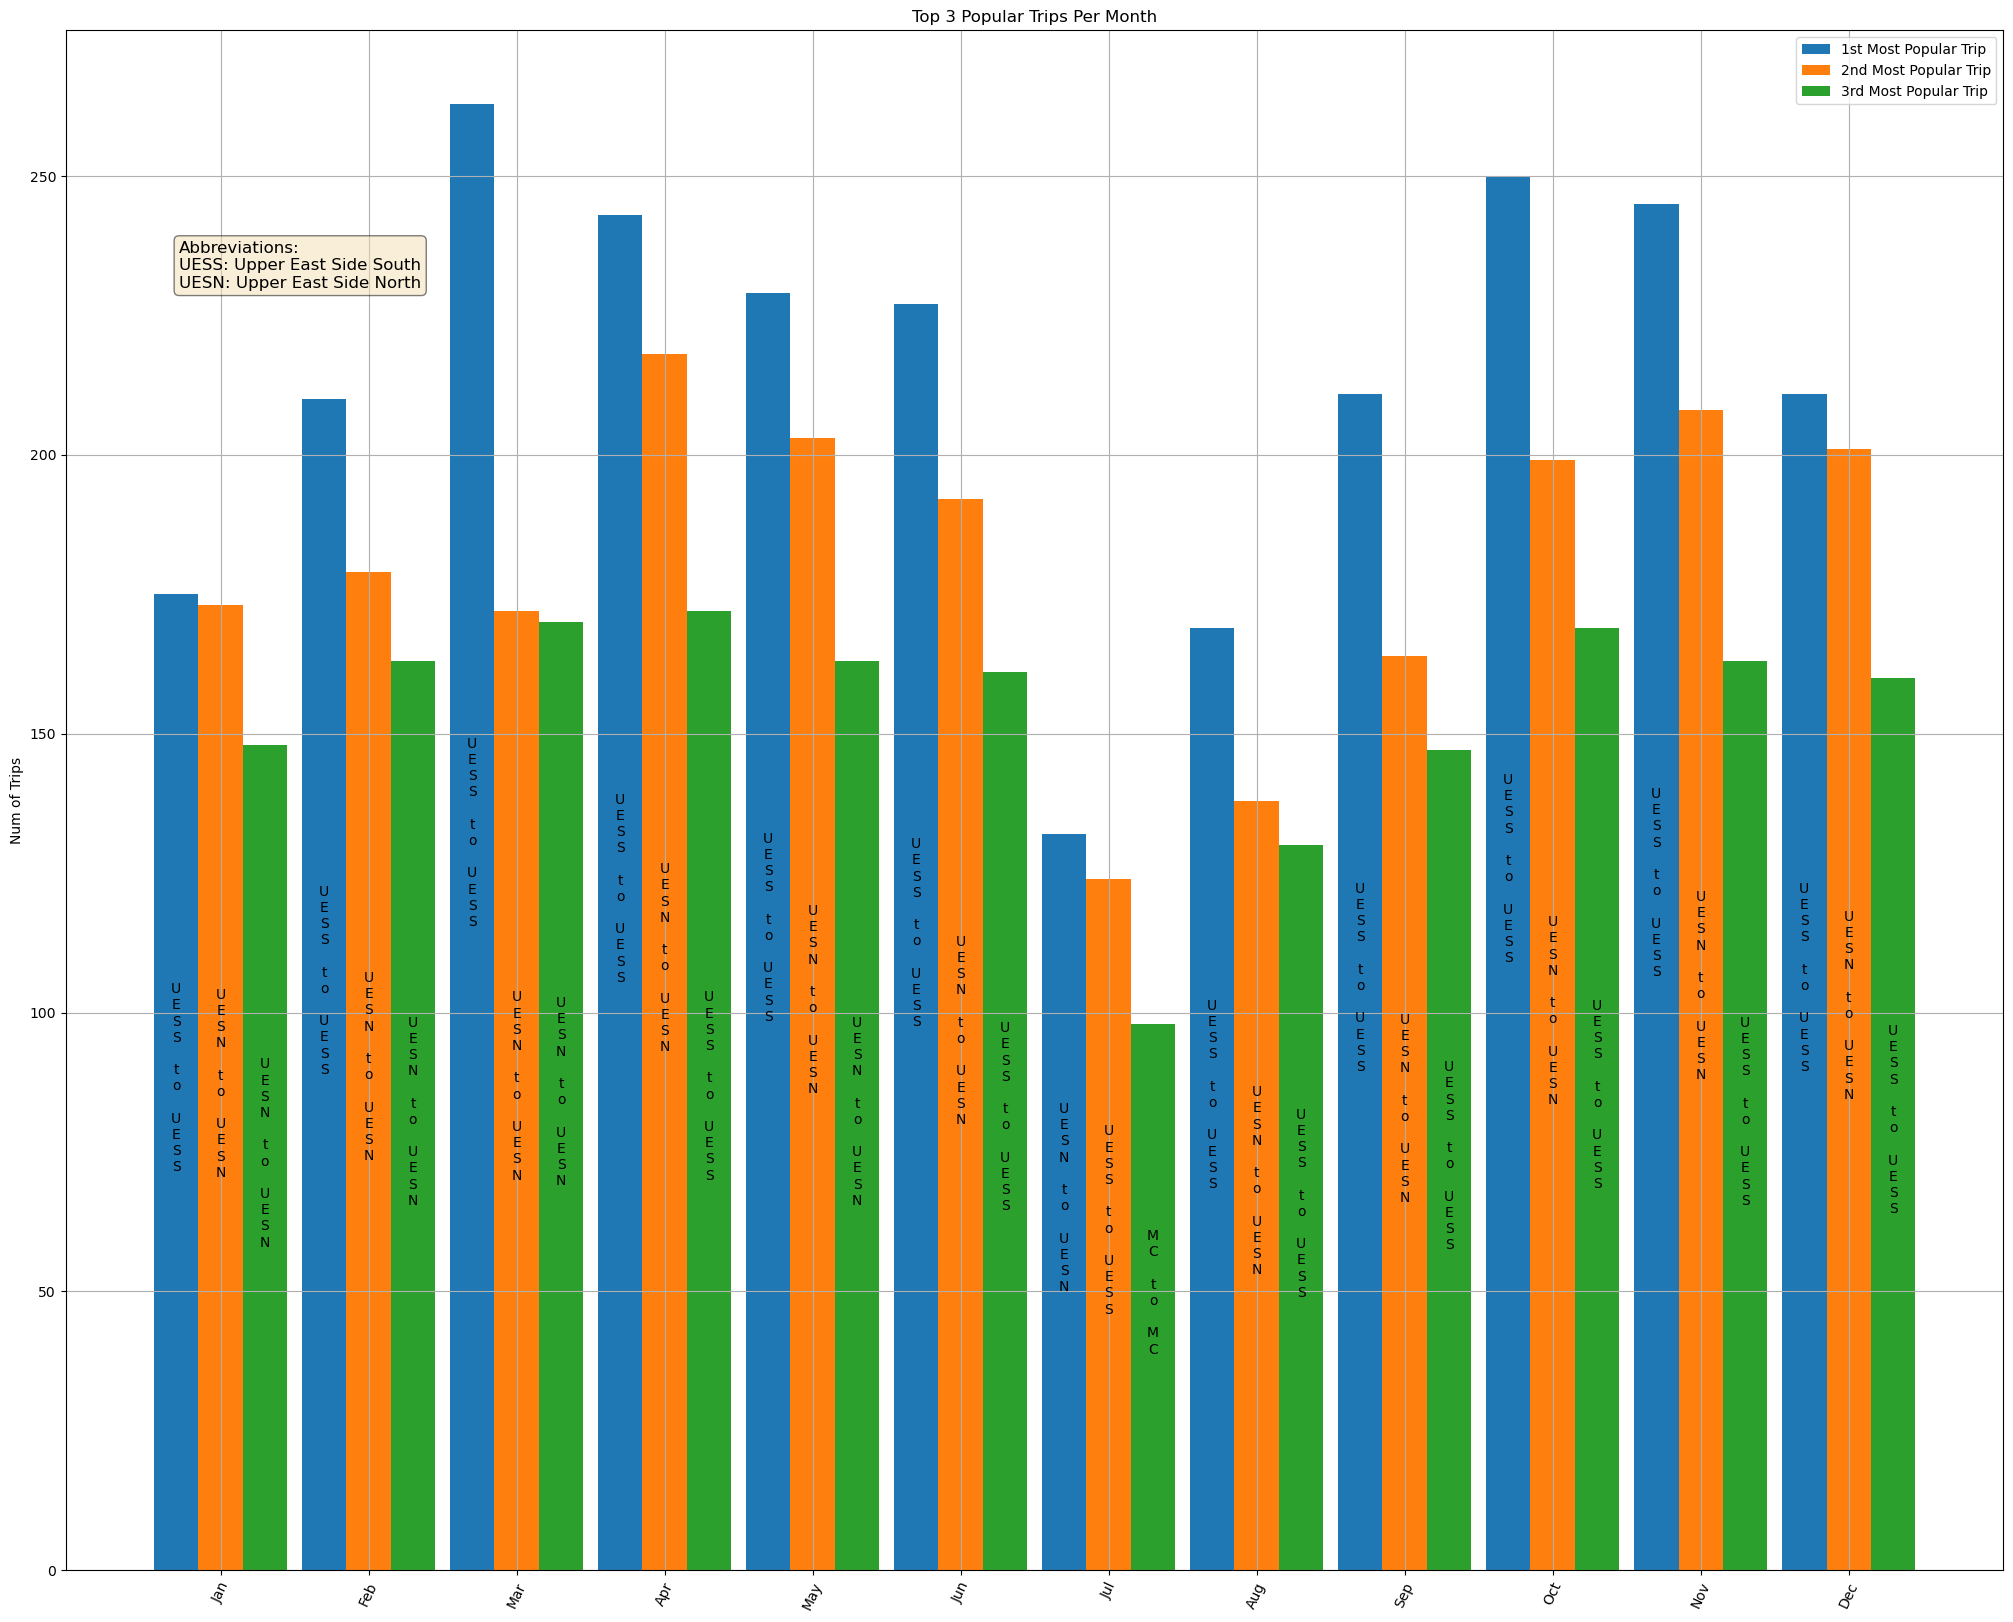

In [29]:
#Display the bar graph
x = np.arange(len(months))
width = 0.3
multiplier = 0

fig, ax = plt.subplots(figsize=(25,20))

counter = 0
for the_rank, the_count in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, the_count, width, label=the_rank)
    ax.bar_label(rects, print_trip_name(counter), label_type='center', padding=3)
    multiplier += 1
    counter += 1

ax.set_ylabel('Num of Trips')
ax.set_title('Top 3 Popular Trips Per Month')
ax.set_xticks(x+width)
ax.set_xticklabels(months, rotation=65)
ax.legend()

trip_abbr_string = '\n'.join(("Abbreviations:", "UESS: Upper East Side South", "UESN: Upper East Side North"))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(.02, 230 ,trip_abbr_string, fontsize=12, bbox=props)
ax.grid(True)

plt.show()

In [30]:
#show number of trips into a particular location
inDeg = tripGraph.inDegrees
inDeg.orderBy(desc("inDegree")).show(5, truncate=False)

/opt/conda/lib/python3.7/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------------------------+--------+
|id                       |inDegree|
+-------------------------+--------+
|Upper East Side North    |16832   |
|Upper East Side South    |16121   |
|Midtown Center           |14455   |
|Murray Hill              |11754   |
|Times Sq/Theatre District|11486   |
+-------------------------+--------+
only showing top 5 rows



In [31]:
#show number of trips leaving a particular location
outDeg = tripGraph.outDegrees
outDeg.orderBy(desc("outDegree")).show(5, truncate=False)

+----------------------------+---------+
|id                          |outDegree|
+----------------------------+---------+
|Upper East Side South       |18365    |
|JFK Airport                 |18340    |
|Upper East Side North       |16578    |
|Midtown Center              |15634    |
|Penn Station/Madison Sq West|12920    |
+----------------------------+---------+
only showing top 5 rows



## Analysis for Graph
##### Bar graph shows the top 3 most frequent trips taken per month throughout 2022. 

##### Graph suggests that the most popular trips were between Upper East Side North and Upper East Side South. This is true for all months throughout 2022. This is further supported by the inDegree and outDegree tables that show Upper East Side North and Upper East Side South of having high counts of being both the pick up area and also the drop off area. (Interesting side note: more people take the taxi after landing at JFK airport than the number of people taking the taxi to JFK airport.)

##### It is also good to note that the graph is consistent with the line graphs from above. The peaks denoting an increase in taxi rides is probably due to avoiding cold (non-snow) weather. Last chance to take the taxi before snowfall begins.

## GraphFrame Motif

In [32]:
#make connections between vertices (locations)
motifs = tripGraph.find("(a)-[ab]->(b)")

In [33]:
motifs.printSchema()

root
 |-- a: struct (nullable = false)
 |    |-- VendorID: long (nullable = true)
 |    |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |    |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |    |-- passenger_count: double (nullable = true)
 |    |-- trip_distance: double (nullable = true)
 |    |-- RatecodeID: double (nullable = true)
 |    |-- store_and_fwd_flag: string (nullable = false)
 |    |-- PULocationID: long (nullable = true)
 |    |-- DOLocationID: long (nullable = true)
 |    |-- payment_type: long (nullable = true)
 |    |-- fare_amount: double (nullable = true)
 |    |-- extra: double (nullable = true)
 |    |-- mta_tax: double (nullable = true)
 |    |-- tip_amount: double (nullable = true)
 |    |-- tolls_amount: double (nullable = true)
 |    |-- improvement_surcharge: double (nullable = true)
 |    |-- total_amount: double (nullable = true)
 |    |-- congestion_surcharge: double (nullable = true)
 |    |-- airport_fee: double (nullable = true)
 

In [34]:
#show those connections
motifUES = motifs.selectExpr("*", "a.`tpep_pickup_datetime` as pickup_time", "a.`tpep_dropoff_datetime` as dropoff_time").where(("a.id == 'Upper East Side North'") or ("a.id == 'Upper East Side South'"))

In [35]:
motifUES.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
#Contains only a smaller sample size of dataset to avoid reaching the max limit.
df_2022_01_sample = df_2022_01.sample(0.005)
df_2022_02_sample = df_2022_02.sample(0.005)
df_2022_03_sample = df_2022_03.sample(0.005)
df_2022_04_sample = df_2022_04.sample(0.005)
df_2022_05_sample = df_2022_05.sample(0.005)
df_2022_06_sample = df_2022_06.sample(0.005)
df_2022_07_sample = df_2022_07.sample(0.005)
df_2022_08_sample = df_2022_08.sample(0.005)
df_2022_09_sample = df_2022_09.sample(0.005)
df_2022_10_sample = df_2022_10.sample(0.005)
df_2022_11_sample = df_2022_11.sample(0.005)
df_2022_12_sample = df_2022_12.sample(0.005)

In [37]:
#Prep the data just like above. Combine the data then rename the columns.
df_2022_sample = df_2022_01_sample.union(df_2022_02_sample).union(df_2022_03_sample).union(df_2022_04_sample).union(df_2022_05_sample).union(df_2022_06_sample).union(df_2022_07_sample).union(df_2022_08_sample).union(df_2022_09_sample).union(df_2022_10_sample).union(df_2022_11_sample).union(df_2022_12_sample)
df_2022_sample_joinedPU = df_2022_sample.join(df_location_mapping, df_2022_sample.PULocationID == df_location_mapping.location_i, "inner")
df_2022_sample_joinedPURenamed = df_2022_sample_joinedPU.withColumnRenamed("X", "PULon").withColumnRenamed("Y", "PULat").withColumnRenamed("borough", "PUborough").withColumnRenamed("location_i", "PUlocation_i").withColumnRenamed("shape_area", "PUshape_area").withColumnRenamed("shape_leng", "PUshape_leng").withColumnRenamed("zone", "PUzone").drop("objectid")
df_2022_sample_joinedPUDO = df_2022_sample_joinedPURenamed.join(df_location_mapping, df_2022_sample_joinedPURenamed.DOLocationID == df_location_mapping.location_i, "inner")
df_2022_sample_joinedPUDORenamed = df_2022_sample_joinedPUDO.withColumnRenamed("X", "DOLon").withColumnRenamed("Y", "DOLat").withColumnRenamed("borough", "DOborough").withColumnRenamed("location_i", "DOlocation_i").withColumnRenamed("shape_area", "DOshape_area").withColumnRenamed("shape_leng", "DOshape_leng").withColumnRenamed("zone", "DOzone").drop("objectid")
df_2022_sample_cleaned = df_2022_sample_joinedPUDORenamed.fillna('')

In [38]:
df_2022_sample_cleaned.count()

1972

In [39]:
df_2022_sample_cleaned.show(5, truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------------+----------------+---------+------------+-----------------+---------------+-----------------------+-----------------+----------------+---------+------------+-----------------+---------------+---------------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|PULon            |PULat           |PUborough|PUlocation_i|PUshape_area     |PUshape_leng   |PUzone                 |DOLon            |DOLat           |DOborough|DOlocation_i|DOshape_area     |DOshape_leng   |DOzone         

In [40]:
#Change column type to String and coordinates to Double
df_map1 = df_2022_sample_cleaned.withColumn("tpep_pickup_datetime", df_2022_sample_cleaned.tpep_pickup_datetime.cast(StringType())).withColumn("tpep_dropoff_datetime", df_2022_sample_cleaned.tpep_dropoff_datetime.cast(StringType())).withColumn("PULon", df_2022_sample_cleaned.PULon.cast(DoubleType())).withColumn("PULat", df_2022_sample_cleaned.PULat.cast(DoubleType())).withColumn("DOLon", df_2022_sample_cleaned.DOLon.cast(DoubleType())).withColumn("DOLat", df_2022_sample_cleaned.DOLat.cast(DoubleType()))

In [41]:
df_map1.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- PULon: double (nullable = true)
 |-- PULat: double (nullable = true)
 |-- PUborough: string (nullable = false)
 |-- PUlocation_i: string (n

In [42]:
#convert spark sql Dataframe to Pandas Dataframe so KeplerGl can read it in below
df_map2 = df_map1.toPandas()

In [43]:
#Configuration of the map
custom_config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [
                {
                    "dataId": [
                        "nyctrips"
                    ],
                    "id": "09vn5a0of",
                    "name": [
                        "tpep_pickup_datetime"
                    ],
                    "type": "timeRange",
                    "value": [
                        1421300098000,
                        1421352890000
                    ],
                    "enlarged": False,
                    "plotType": "histogram",
                    "animationWindow": "free",
                    "yAxis": None,
                    "speed": 1
                }
            ],
            "layers": [
                {
                    "id": "f29m0q",
                    "type": "arc",
                    "config": {
                        "dataId": "nyctrips",
                        "label": "pickup -> dropoff arc",
                        "color": [
                            16,
                            129,
                            136
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "lat0": "PULat",
                            "lng0": "PULon",
                            "lat1": "DOLat",
                            "lng1": "DOLon"
                        },
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.37,
                            "thickness": 1,
                            "colorRange": {
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ],
                                "name": "Global Warming",
                                "type": "sequential"
                            },
                            "sizeRange": [
                                0,
                                10
                            ],
                            "targetColor": [
                                59,
                                30,
                                177
                            ]
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                },
                {
                    "id": "4bonnee",
                    "type": "point",
                    "config": {
                        "dataId": "nyctrips",
                        "label": "pickup",
                        "color": [
                            36,
                            115,
                            189
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "lat": "PULat",
                            "lng": "PULon",
                            "altitude": None
                        },
                        "isVisible": False,
                        "visConfig": {
                            "radius": 1,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": [
                                36,
                                115,
                                189
                            ],
                            "colorRange": {
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ],
                                "name": "Global Warming",
                                "type": "sequential"
                            },
                            "strokeColorRange": {
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ],
                                "name": "Global Warming",
                                "type": "sequential"
                            },
                            "radiusRange": [
                                0,
                                50
                            ],
                            "filled": True
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                },
                {
                    "id": "pnidnry",
                    "type": "point",
                    "config": {
                        "dataId": "nyctrips",
                        "label": "dropoff",
                        "color": [
                            34,
                            63,
                            154
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "lat": "DOLat",
                            "lng": "DOLon",
                            "altitude": None
                        },
                        "isVisible": False,
                        "visConfig": {
                            "radius": 8,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": [
                                34,
                                63,
                                154
                            ],
                            "colorRange": {
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ],
                                "name": "Global Warming",
                                "type": "sequential"
                            },
                            "strokeColorRange": {
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300"
                                ],
                                "name": "Global Warming",
                                "type": "sequential"
                            },
                            "radiusRange": [
                                0,
                                50
                            ],
                            "filled": True
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                },
                {
                    "id": "nk502ze",
                    "type": "hexagon",
                    "config": {
                        "dataId": "nyctrips",
                        "label": "tripstart",
                        "color": [
                            255,
                            153,
                            31
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "lat": "PULat",
                            "lng": "PULon"
                        },
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "worldUnitSize": 0.1,
                            "resolution": 8,
                            "colorRange": {
                                "name": "ColorBrewer Greens-6",
                                "type": "singlehue",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#edf8e9",
                                    "#c7e9c0",
                                    "#a1d99b",
                                    "#74c476",
                                    "#31a354",
                                    "#006d2c"
                                ]
                            },
                            "coverage": 1,
                            "sizeRange": [
                                0,
                                500
                            ],
                            "percentile": [
                                0,
                                100
                            ],
                            "elevationPercentile": [
                                0,
                                100
                            ],
                            "elevationScale": 10,
                            "enableElevationZoomFactor": True,
                            "colorAggregation": "count",
                            "sizeAggregation": "count",
                            "enable3d": True
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                },
                {
                    "id": "t6vgjpr",
                    "type": "hexagon",
                    "config": {
                        "dataId": "nyctrips",
                        "label": "tripend",
                        "color": [
                            18,
                            92,
                            119
                        ],
                        "highlightColor": [
                            252,
                            242,
                            26,
                            255
                        ],
                        "columns": {
                            "lat": "DOLat",
                            "lng": "DOLon"
                        },
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "worldUnitSize": 0.1,
                            "resolution": 8,
                            "colorRange": {
                                "name": "ColorBrewer Reds-6",
                                "type": "singlehue",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#fee5d9",
                                    "#fcbba1",
                                    "#fc9272",
                                    "#fb6a4a",
                                    "#de2d26",
                                    "#a50f15"
                                ]
                            },
                            "coverage": 1,
                            "sizeRange": [
                                0,
                                500
                            ],
                            "percentile": [
                                0,
                                100
                            ],
                            "elevationPercentile": [
                                0,
                                100
                            ],
                            "elevationScale": 10,
                            "enableElevationZoomFactor": True,
                            "colorAggregation": "average",
                            "sizeAggregation": "average",
                            "enable3d": True
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [
                                    255,
                                    255,
                                    255
                                ],
                                "size": 18,
                                "offset": [
                                    0,
                                    0
                                ],
                                "anchor": "start",
                                "alignment": "center"
                            }
                        ]
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                }
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "nyctrips": [
                            {
                                "name": "VendorID",
                                "format": None
                            },
                            {
                                "name": "tpep_pickup_datetime",
                                "format": None
                            },
                            {
                                "name": "tpep_dropoff_datetime",
                                "format": None
                            },
                            {
                                "name": "passenger_count",
                                "format": None
                            },
                            {
                                "name": "trip_distance",
                                "format": None
                            }
                        ]
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": False
                },
                "brush": {
                    "size": 0.5,
                    "enabled": False
                },
                "geocoder": {
                    "enabled": False
                },
                "coordinate": {
                    "enabled": False
                }
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {
                "currentTime": None,
                "speed": 1
            }
        },
        "mapState": {
            "bearing": 1.8352582948341034,
            "dragRotate": True,
            "latitude": 40.741330569522944,
            "longitude": -73.96869008211753,
            "pitch": 56.767699783692606,
            "zoom": 10.995954634692149,
            "isSplit": False
        },
        "mapStyle": {
            "styleType": "dark",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "border": False,
                "building": True,
                "label": False,
                "land": True,
                "road": True,
                "water": True
            },
            "threeDBuildingColor": [
                9.665468314072013,
                17.18305478057247,
                31.1442867897876
            ],
            "mapStyles": {}
        }
    }
}

In [44]:
#Load data into KeplerGl
mapKepler = KeplerGl(height=600, config=custom_config)
mapKepler.add_data(data=df_map2, name="nyctrips")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/conda/lib/python3.7/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [45]:
#use this command to display the map in a regular Jupyter notebook
#mapKepler

In [46]:
#use this command to display map in Databricks
#def display_kepler(kmap:KeplerGl, height=800, width=1200) -> None:
#    displayHTML(kmap._repr_html_().decode("utf-8").replace(".height||400", f".height||{height}").replace(".width||400", f".width||{width}"))
#display_kepler(mapKepler)

In [47]:
#if the map could not be displayed in Kaggle, then run this following line. It will save the map as a HTML file. It will be saved in current directory. You can then open the file in a browser. I've included a jpg of the map on the top.
mapKepler.save_to_html(file_name='NYCTaxiAnalysis_2022.html')

Map saved to NYCTaxiAnalysis_2022.html!


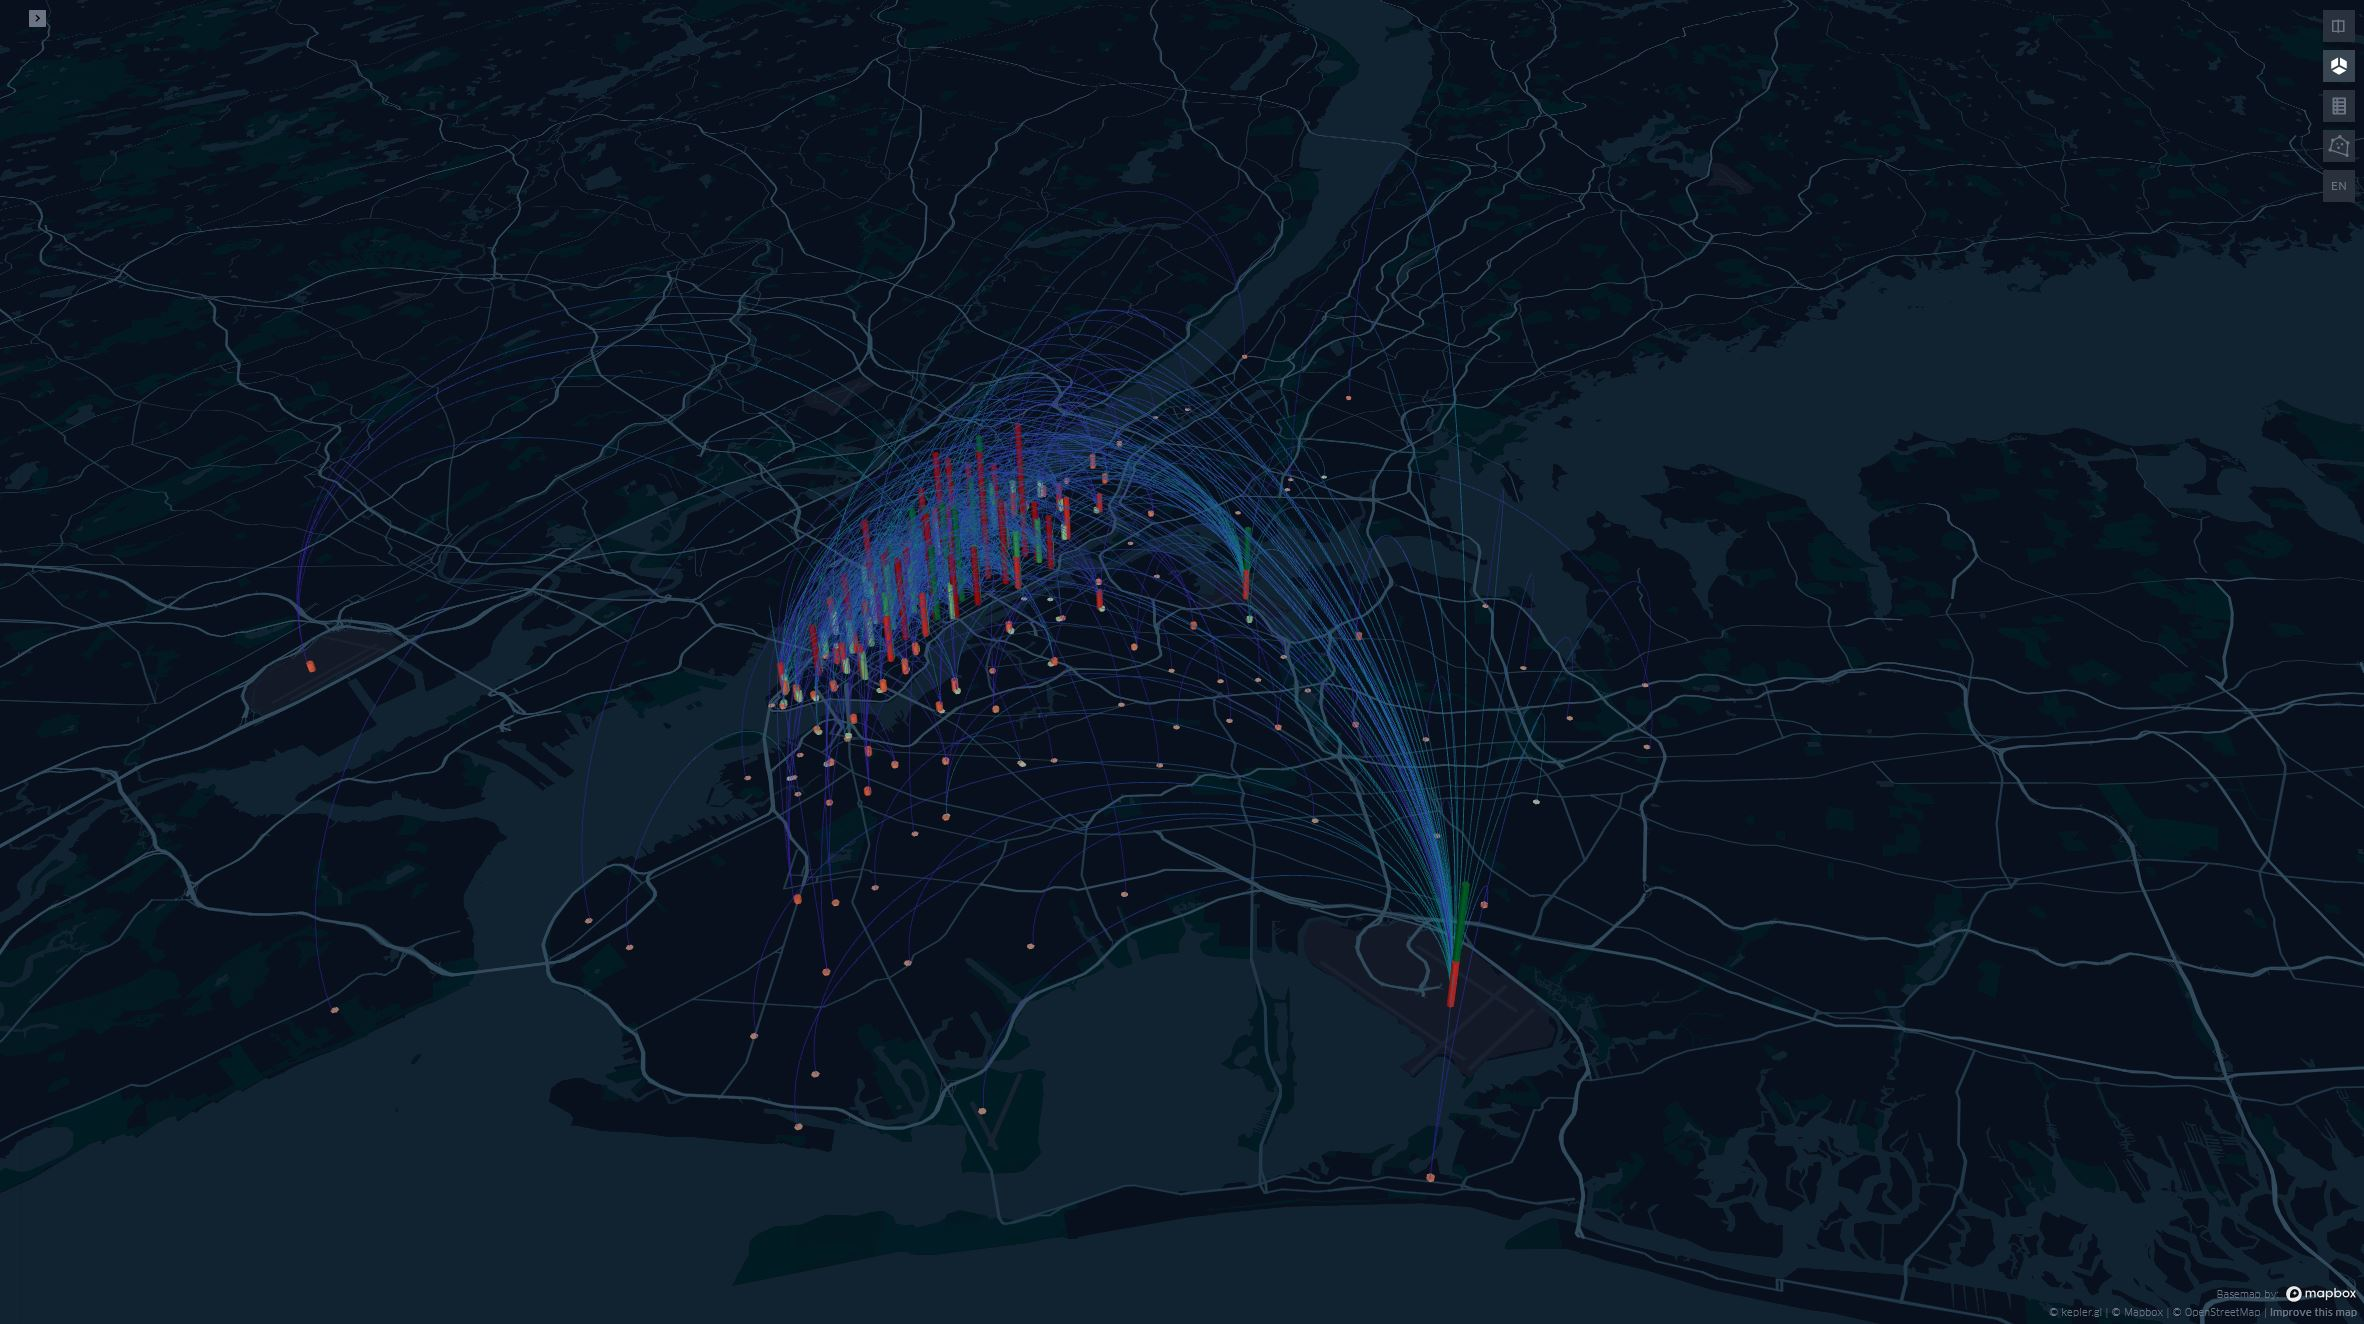

## Map Analysis
##### The following map is generated in the last line of code on the bottom. It shows the pickup spots (green), dropoff spots (red), and also the trip in between. The taller the hexagon, the higher the density of that being a prominent spot for pickup or dropoff. As seen in the map, most pickup or dropoff spots are located near the center of the city. This is supported by the plots and bar graphs above. This further supports that most trips are about 5 to 10 miles on average, as mentioned in plots analysis above. There are also some trips going further out and away from the center of the city.

## Conclusion
##### Average trip fees stayed fairly constant throughout the 2022 year. However, the number of trips and the average trip distance vary throughout the year. This means trip fees do not greatly affect people's decision of whether or not to take the taxi. Other factors such as weather plays a bigger role. It is likely that people take the taxi to avoid the heat during summer and that people avoid taking the taxi during snow season. Including additional dataset related to 2022 weather may help. Majority of trips' pickup and dropoff spots are on average between 5 to 10 miles. Since this is a relatively short distance, perhaps this is why average trip fees do not play a large role in people deciding whether or not to take a taxi.